In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv("train.csv")


In [5]:
# NaN oranlarını yüzdelik olarak hesapla (Train)
nan_ratios_train = train_data.isnull().mean() * 100
nan_ratios_train = nan_ratios_train[nan_ratios_train > 0].sort_values(ascending=False)

# NaN oranlarını yüzdelik olarak hesapla (Test)

# Sonuçları yazdır
print("Train verisindeki NaN oranları (%):")
print(nan_ratios_train)


# %15'ten fazla NaN içeren sütunları tespit et
high_nan_cols_train = nan_ratios_train[nan_ratios_train > 15].index

# Her train setinden de bu sütunları sil
train_data = train_data.drop(columns=high_nan_cols_train, errors='ignore')


Train verisindeki NaN oranları (%):
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64


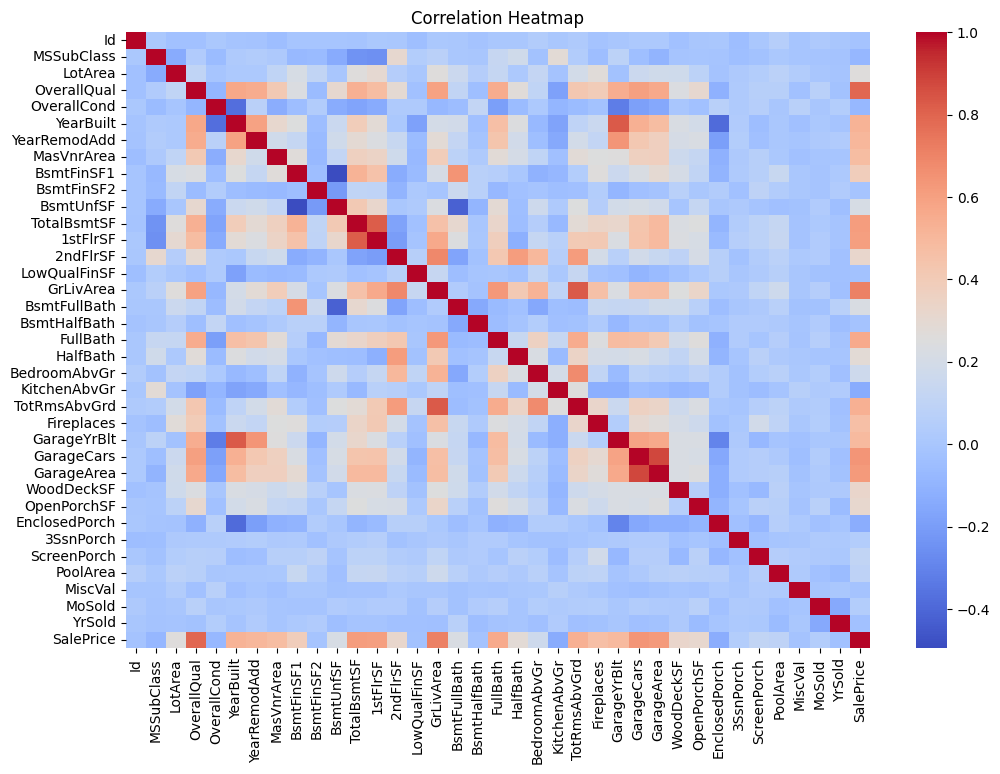

In [6]:
# 2.3 Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_cols = train_data.select_dtypes(include=[np.number]).columns
corr = train_data[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

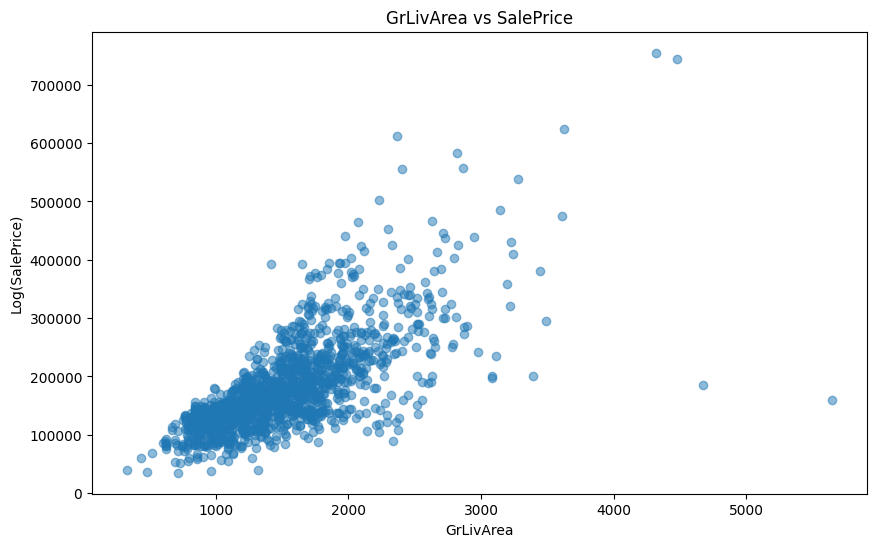

In [7]:
# 2.4 Scatter Plot: GrLivArea vs SalePrice
plt.figure(figsize=(10, 6))
plt.scatter(train_data['GrLivArea'], train_data['SalePrice'], alpha=0.5)
plt.title('GrLivArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('Log(SalePrice)')
plt.show()

In [8]:
#Future Engineering for TotalSF, HouseAge,RemodAge
train_data['TotalSF'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
train_data['HouseAge'] = train_data['YrSold'] - train_data['YearBuilt']
train_data['RemodAge'] = train_data['YrSold'] - train_data['YearRemodAdd']




In [9]:
# Log-transform skewed numerical features
skewed_cols_train = ['LotArea', 'GrLivArea', 'TotalSF']
for col in skewed_cols_train:
    train_data[col] = np.log1p(train_data[col])


In [10]:
# 1. Null (NaN) içeren tüm sütunları al
null_cols = train_data.columns[train_data.isnull().any()]

# 2. Kategorik ve kategorik olmayan null sütunları ayır
categorical_nulls = [col for col in null_cols if train_data[col].dtype == 'object']
numeric_nulls = [col for col in null_cols if train_data[col].dtype != 'object']

# 3. Kategorik null sütunları mod (en sık görülen değer) ile doldur
for col in categorical_nulls:
    mode_val = train_data[col].mode()[0]
    train_data[col].fillna(mode_val, inplace=True)

# 4. Sayısal null sütunları medyan ile doldur
for col in numeric_nulls:
    median_val = train_data[col].median()
    train_data[col].fillna(median_val, inplace=True)

print("Tüm null değerler dolduruldu.")


Tüm null değerler dolduruldu.


In [11]:
train_data.isnull().sum().sum()

0

In [12]:
# Outlier işlemi sadece int tipindeki sütunlara uygulanacak
int_columns = train_data.select_dtypes(include=['int64']).columns

for col in int_columns:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Aykırı değerleri sınıra getir (cap)
    train_data[col] = np.where(train_data[col] < lower_bound, lower_bound,
              np.where(train_data[col] > upper_bound, upper_bound, train_data[col]))

In [13]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor




# Özellikler ve hedef değişkeni belirle
X = train_data.drop(columns=["SalePrice","Id"])
y = train_data["SalePrice"]

# Kategorik sütunları sayıya çevir
cat_cols = X.select_dtypes(include=["object"]).columns
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

# Eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)



In [14]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# DÜZGÜN İMPORT!
from xgboost import XGBRegressor

# Kategorik sütunları sayıya çevir
cat_cols = X.select_dtypes(include=["object"]).columns
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

# Eğitim/test ayırma
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Parametre arama aralığı
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'subsample': [0.6, 0.8, 1.0]
}

# Model tanımı
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_params,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Modeli eğit
grid_search.fit(X_train, y_train)

# Sonuçlar
print("En iyi parametreler:", grid_search.best_params_)
print("CV (Train) R²  XGB skoru:", grid_search.best_score_)

# Test performansı
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest Performansı")
print(f"R² Score : {r2_score(y_test, y_pred):.4f}")
print(f"RMSE     : {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"MAE      : {mean_absolute_error(y_test, y_pred):.2f}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
CV (Train) R²  XGB skoru: 0.9116117235187815

Test Performansı
R² Score : 0.9292
RMSE     : 18608.01
MAE      : 12646.16


In [15]:
# Parametre aralığı
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Model
rf_model = RandomForestRegressor(random_state=42)

# Grid Search
rf_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    scoring='r2',
    cv=15,
    n_jobs=-1,
    verbose=1
)

# Eğit
rf_search.fit(X_train, y_train)

# Sonuçlar
print("\n[RANDOM FOREST]")
print("En iyi parametreler:", rf_search.best_params_)
print("CV (Train) R² skoru:", rf_search.best_score_)

# Test performansı
rf_best = rf_search.best_estimator_
y_pred_rf = rf_best.predict(X_test)

print("\nTest Performansı")
print(f"R² Score : {r2_score(y_test, y_pred_rf):.4f}")
print(f"RMSE     : {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"MAE      : {mean_absolute_error(y_test, y_pred_rf):.2f}")


Fitting 15 folds for each of 24 candidates, totalling 360 fits


C:\Users\salih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\salih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\salih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pa


[RANDOM FOREST]
En iyi parametreler: {'bootstrap': False, 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200}
CV (Train) R² skoru: 0.8810031072657878

Test Performansı
R² Score : 0.9035
RMSE     : 21726.09
MAE      : 15497.65


In [16]:
from catboost import CatBoostRegressor

# Parametre aralığı
cat_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7],
    'iterations': [100, 200]
}

# Model
cat_model = CatBoostRegressor(random_state=42, verbose=0)

# Grid Search
cat_search = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_params,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Eğit
cat_search.fit(X_train, y_train)

# Sonuçlar
print("\n[CATBOOST]")
print("En iyi parametreler:", cat_search.best_params_)
print("CV (Train) R² skoru:", cat_search.best_score_)

# Test performansı
cat_best = cat_search.best_estimator_
y_pred_cat = cat_best.predict(X_test)

print("\nTest Performansı")
print(f"R² Score : {r2_score(y_test, y_pred_cat):.4f}")
print(f"RMSE     : {np.sqrt(mean_squared_error(y_test, y_pred_cat)):.2f}")
print(f"MAE      : {mean_absolute_error(y_test, y_pred_cat):.2f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits

[CATBOOST]
En iyi parametreler: {'depth': 5, 'iterations': 200, 'learning_rate': 0.1}
CV (Train) R² skoru: 0.9140638918137336

Test Performansı
R² Score : 0.9337
RMSE     : 18007.49
MAE      : 12284.08
